<a href="https://colab.research.google.com/github/kurihara-ryo/cesarean-pasaran/blob/main/FU_KURIHARA_Ryo_%E6%BC%94%E7%BF%92%E8%AA%B2%E9%A1%8C_%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0%E2%85%A2_0304.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#【課題】と書いてあるセルでは、自分でプログラムを作成してください。
# 実行ボタンを押してプログラムの動作確認を行い、Google Classroomから提出してください。
# 提出する際は、コメント(#から始まる部分)を削除せずに残してください。
# 〆切が近いので、後回しにせず講義時間中に手を動かしてプログラムを作成すること。

In [ ]:
#### おさらい：分類モデルの学習と予測精度の評価
# 「プログラミングⅡ」でも扱った心不全患者のデータを使って、
# sklearnを用いた機械学習の流れについて復習します。

import numpy as np
import pandas as pd
import gdown
url='https://drive.google.com/uc?export=download&id=170BvFfMQJBI8jueqdMXuJiB910bbKSiN'
gdown.download(url, 'heart_failure_clinical_records.csv', quiet=False)
df = pd.read_csv('heart_failure_clinical_records.csv')
display(df)

# heart_failure_clinical_records.csvは、
# 心不全患者の臨床情報とその死亡事例について記載したデータです。
# 各患者について、年齢、持病、血液検査などの測定値と、
# 調査から130日以内の死亡の有無(1:死亡、0:生存)が書かれています。
# このデータを使って、患者の臨床情報から死亡を予測する分類モデルを作ります。

Downloading...
From: https://drive.google.com/uc?export=download&id=170BvFfMQJBI8jueqdMXuJiB910bbKSiN
To: /content/heart_failure_clinical_records.csv
100%|██████████| 11.5k/11.5k [00:00<00:00, 16.8MB/s]


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,0


In [ ]:
# 「プログラミングⅡ」の最終回で学んだように、
# ハイパーパラメータの調整を含む教師あり学習の流れは以下のようになります。

# 必要なモジュール一式を用意
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

# 乱数シードを設定
# 再現性のために重要
# ※課題の採点の都合上、この値は変更しないでください
seed = 42

# データフレームをX,yに分ける
df_X = df.iloc[:, 0:-1] # 最初から最後の列の1つ前まで
df_y = df.iloc[:, -1] # 最後の列

# X,yをそれぞれ学習データとテストデータに分ける
X_train,  X_test, y_train, y_test = train_test_split(df_X, df_y, train_size=0.7, shuffle=True, random_state=seed)
print('X_train shape {}'.format(X_train.shape))
print('X_test shape {}'.format(X_test.shape))
print('y_train shape {}'.format(y_train.shape))
print('y_test shape {}'.format(y_test.shape))

# X_trainの前処理
# 標準化：各特徴量を平均0、標準偏差1となるように変換
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# X_testの前処理
# 学習データと同じ基準で変換するために、X_trainに使ったインスタンスを流用
X_test = scaler.transform(X_test)

# モデルのインスタンスを作成
model = LogisticRegression()
# ハイパラの探索範囲を指定
# ロジスティック回帰の正則化項の係数C
param_grid = {'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]}

# CVの方法を指定
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

# グリッドサーチの方法を指定
# 精度指標にはaccuracyを使用
gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy')

# グリッドサーチを実行
# accuracyの最も良いハイパラを選択
gs.fit(X=X_train, y=y_train)
print('best hyperparameter: {}'.format(gs.best_params_))
print('best accuracy: {}'.format(gs.best_score_))

# テストデータに対する予測精度を評価
y_test_pred = gs.predict(X_test) # 予測クラス
y_test_prob = gs.predict_proba(X_test) # クラス確率

accuracy_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)
print('accuracy on test data: {}'.format(accuracy_test))

X_train shape (209, 11)
X_test shape (90, 11)
y_train shape (209,)
y_test shape (90,)
best hyperparameter: {'C': 0.05}
best accuracy: 0.7515679442508711
accuracy on test data: 0.7


【課題】上で計算したy_test_predを使って、テストデータに対するF1スコア、recall、precisionを計算して表示してください。

In [ ]:
from sklearn.metrics import f1_score, accuracy_score,recall_score, precision_score


f1_test = f1_score(y_true=y_test, y_pred=y_test_pred)
recall_test =recall_score (y_true=y_test,y_pred=y_test_pred)
precision_test = precision_score(y_true = y_test,y_pred = y_test_pred)
print('F1 on test data: {}'.format(f1_test))
print('recall on test data: {}'.format(recall_test))
print('precision on test data: {}'.format(precision_test))

F1 on test data: 0.05128205128205128
recall on test data: 0.02702702702702703
precision on test data: 0.5


In [ ]:
#### 分類モデルの精度指標
# 上の例ではaccuracyを精度指標としてグリッドサーチによりハイパラを決め、
# 最適なハイパラと学習データ全体を使って最終的なモデルを作成して、
# テストデータに対するaccuracyやF1スコアなどを評価しました。
# グリッドサーチの精度指標としてaccuracy以外のものを使うこともできます。
# 用いる精度指標によって最適なハイパラの値が変わることもあります。

# グリッドサーチの精度指標にF1を使用
gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='f1')

# F1の最も良いハイパラを選択
gs.fit(X=X_train, y=y_train)
print('best hyperparameter: {}'.format(gs.best_params_))
print('best F1: {}'.format(gs.best_score_))

# テストデータに対する予測精度を評価
y_test_pred = gs.predict(X_test) # 予測クラス
y_test_prob = gs.predict_proba(X_test) # クラス確率

accuracy_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)
f1_test = f1_score(y_true=y_test, y_pred=y_test_pred)
print('accuracy on test data: {}'.format(accuracy_test))
print('F1 on test data: {}'.format(f1_test))
# 最適なハイパラはC=5となり、テストデータに対するaccuracyやF1スコアも変化しました。

best hyperparameter: {'C': 5}
best F1: 0.4758454106280193
accuracy on test data: 0.6777777777777778
F1 on test data: 0.4727272727272727


In [ ]:
# accuracy、F1スコアなどの精度指標はクラス確率の閾値に依存します。
# そのため分類モデルの性能を総合的に判断したい場合には、
# ROC AUCなどの閾値に依存しない精度指標を用いることが多いです。
from sklearn.metrics import roc_auc_score

# グリッドサーチの精度指標にROC AUCを使用
gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc')

# ROC AUCの最も良いハイパラを選択
gs.fit(X=X_train, y=y_train)
print('best hyperparameter: {}'.format(gs.best_params_))
print('best ROC AUC: {}'.format(gs.best_score_))

# テストデータに対する予測精度を評価
y_test_pred = gs.predict(X_test) # 予測クラス
y_test_prob = gs.predict_proba(X_test) # クラス確率

accuracy_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)
f1_test = f1_score(y_true=y_test, y_pred=y_test_pred)
# roc_auc_score()の引数y_scoreには、クラス1のクラス確率を渡す
roc_auc_test = roc_auc_score(y_true=y_test, y_score=y_test_prob[:, 1])
print('accuracy on test data: {}'.format(accuracy_test))
print('F1 on test data: {}'.format(f1_test))
print('ROC AUC on test data: {}'.format(roc_auc_test))

best hyperparameter: {'C': 0.01}
best ROC AUC: 0.7690314909957767
accuracy on test data: 0.5888888888888889
F1 on test data: 0.05128205128205128
ROC AUC on test data: 0.7577766445690974


In [ ]:
# ROC AUCの値だけでなくROC曲線も見たい場合、roc_curve()を使います。
# roc_curve()の戻り値は、クラス確率の閾値(threshold)を色々に変化させたときの、
# true positive rate (TPR)、false positive rate (FPR)の値が入ったアレイです。
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_true=y_test, y_score=y_test_prob[:, 1])
print('True positive rate:\n{}\n'.format(tpr))
print('False positive rate:\n{}\n'.format(fpr))
print('Class probability threshold:\n{}'.format(threshold))

True positive rate:
[0.         0.02702703 0.02702703 0.27027027 0.27027027 0.32432432
 0.32432432 0.37837838 0.37837838 0.40540541 0.40540541 0.43243243
 0.43243243 0.45945946 0.45945946 0.62162162 0.62162162 0.7027027
 0.7027027  0.72972973 0.72972973 0.78378378 0.78378378 0.83783784
 0.83783784 0.89189189 0.89189189 0.91891892 0.91891892 0.94594595
 0.94594595 0.97297297 0.97297297 1.         1.        ]

False positive rate:
[0.         0.         0.01886792 0.01886792 0.03773585 0.03773585
 0.11320755 0.11320755 0.13207547 0.13207547 0.1509434  0.1509434
 0.16981132 0.16981132 0.22641509 0.22641509 0.24528302 0.24528302
 0.26415094 0.26415094 0.33962264 0.33962264 0.37735849 0.37735849
 0.45283019 0.45283019 0.73584906 0.73584906 0.83018868 0.83018868
 0.86792453 0.86792453 0.90566038 0.90566038 1.        ]

Class probability threshold:
[       inf 0.75953401 0.56181933 0.38189133 0.36963161 0.36112797
 0.33355715 0.32721717 0.32472775 0.32461991 0.31984686 0.31324462
 0.31077751 

Text(0, 0.5, 'True positive rate')

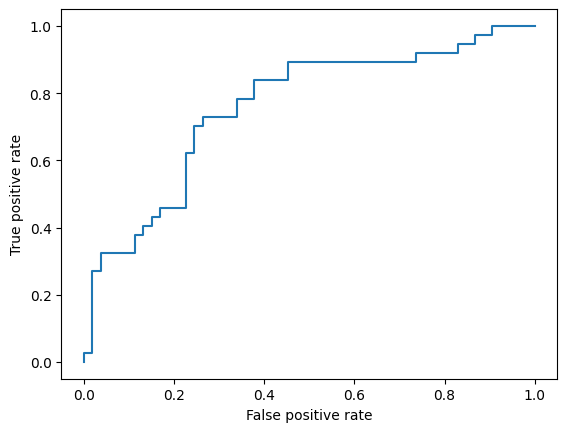

In [ ]:
# FPR、TPRを使ってROC曲線を描く例です。
import matplotlib.pyplot as plt

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

【課題】モデルにランダムフォレストを用いて、ROC AUCを精度指標としてハイパラの最適化を行い、テストデータに対するROC AUCを計算して表示してください。上で計算したロジスティック回帰のROC AUCと比較して、どちらが良かったかコメントの解答欄に書いてください。

*   平等な比較を行うために、学習データ、テストデータ、CVのインスタンスには上の例で作成したのと同じものを流用してください。
*   ランダムフォレストの乱数シード、ハイパラの探索範囲についてはコード内の指定にしたがってください。

In [ ]:
# おさらい：
# ランダムフォレストの分類モデルはRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# モデルのインスタンスを作成
# seedは上の例と同じものを用いる
model = RandomForestClassifier(random_state=seed)
# ハイパラの探索範囲を指定
# ランダムフォレストの木の数n_estimators
param_grid = {'n_estimators': [10, 20, 50, 100]}

# グリッドサーチの精度指標にROC AUCを使用
gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc')

# ROC AUCの最も良いハイパラを選択
gs.fit(X=X_train, y=y_train)
print('best hyperparameter: {}'.format(gs.best_params_))
print('best ROC AUC: {}'.format(gs.best_score_))

# テストデータに対する予測精度を評価
y_test_pred = gs.predict(X_test) # 予測クラス
y_test_prob = gs.predict_proba(X_test) # クラス確率

# roc_auc_score()の引数y_scoreには、クラス1のクラス確率を渡す
roc_auc_test = roc_auc_score(y_true=y_test, y_score=y_test_prob[:, 1])
print('ROC AUC on test data: {}'.format(roc_auc_test))

# 解答欄：テストデータに対するROC AUCが高かったのは、ロジスティック回帰？ランダムフォレスト？
# ランダムフォレスト

best hyperparameter: {'n_estimators': 100}
best ROC AUC: 0.7771362268683697
ROC AUC on test data: 0.7950025497195309


In [ ]:
#### 回帰モデルの学習と予測精度の評価
# 例として、米国の医療費のデータを使用します。

import numpy as np
import pandas as pd
import gdown
url='https://drive.google.com/uc?export=download&id=1ZfRACR6UV3VE2teWDcFhjgOitHUdH6vR'
gdown.download(url, 'medical_costs.csv', quiet=False)
df = pd.read_csv('medical_costs.csv')
display(df)

# medical_costs.csvは、
# 米国の健康保険加入者の医療費について記載したデータです。
# 各加入者について、年齢、BMI、子どもの数、喫煙の有無などの個人情報と、
# 健康保険で負担された医療費の金額(charges、単位は千ドル)が記載されています。
# このデータを使って、加入者の個人情報から医療費を予測する回帰モデルを作ります。
#
# データの出典：
# Kaggle Medical Cost Personal Datasetsから一部改変
# https://www.kaggle.com/datasets/mirichoi0218/insurance

Downloading...
From: https://drive.google.com/uc?export=download&id=1ZfRACR6UV3VE2teWDcFhjgOitHUdH6vR
To: /content/medical_costs.csv
100%|██████████| 10.6k/10.6k [00:00<00:00, 11.6MB/s]


,age,sex,bmi,children,smoker,charges
0,37,male,29.830,2,no,6.406411
1,25,male,26.220,0,no,2.721321
2,52,female,30.780,1,no,10.797336
3,23,male,23.845,0,no,2.395172
4,60,female,36.005,0,no,13.228847
...,...,...,...,...,...,...
319,62,male,26.695,0,yes,28.101333
320,61,male,33.535,0,no,13.143337
321,42,female,32.870,0,no,7.050021
322,23,female,24.225,2,no,22.395744


In [ ]:
# sexやsmokerの列には、male/female、yes/noなどの文字列が入っています。
# このままでは機械学習の入力に使えないので数値データに変換します。
# sexの列について、maleを1、femaleを0に変換するには以下のようにします。

# データフレームのメソッドmap()
# 変換前の文字列をキー、変換後の数値を値とする辞書を指定
df['sex'] = df['sex'].map({'male': 1, 'female': 0})
display(df)

,age,sex,bmi,children,smoker,charges
0,37,1,29.830,2,no,6.406411
1,25,1,26.220,0,no,2.721321
2,52,0,30.780,1,no,10.797336
3,23,1,23.845,0,no,2.395172
4,60,0,36.005,0,no,13.228847
...,...,...,...,...,...,...
319,62,1,26.695,0,yes,28.101333
320,61,1,33.535,0,no,13.143337
321,42,0,32.870,0,no,7.050021
322,23,0,24.225,2,no,22.395744


【課題】smokerの列について、yesを1、noを0に変換して、データフレームを表示してください。

In [ ]:
# データ修復用：
# 課題中にデータを壊してしまったら、以下の2行のコメントを外してデータを作り直しましょう。
df = pd.read_csv('medical_costs.csv')
df['sex'] = df['sex'].map({'male': 1, 'female': 0})

# ここから課題
df['smoker'] = df['smoker'].map({'yes':1, 'no':0})
display(df)

,age,sex,bmi,children,smoker,charges
0,37,1,29.830,2,0,6.406411
1,25,1,26.220,0,0,2.721321
2,52,0,30.780,1,0,10.797336
3,23,1,23.845,0,0,2.395172
4,60,0,36.005,0,0,13.228847
...,...,...,...,...,...,...
319,62,1,26.695,0,1,28.101333
320,61,1,33.535,0,0,13.143337
321,42,0,32.870,0,0,7.050021
322,23,0,24.225,2,0,22.395744


In [ ]:
# 回帰モデルの場合も、全体の流れは分類モデルの場合と変わりません。
# 例として、線形回帰モデルの1種であるリッジ回帰を使います。
# リッジ回帰は線形回帰にL2正則化を導入したモデルであり、
# 主なハイパラは正則化項の係数alphaです。
# 精度指標には回帰モデル用の精度指標を使う必要があります。
# 今回はR2を使用します。

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# モデルのインスタンスを作成
model = Ridge()
# ハイパラの探索範囲を指定
# リッジ回帰の正則化係数alpha
param_grid = {'alpha': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]}

# あとは分類モデルの場合と同様

# 必要なモジュール一式を用意
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

# 乱数シードを設定
# ※課題の採点の都合上、この値は変更しないでください
seed = 42

# データフレームをX,yに分ける
df_X = df.iloc[:, 0:-1] # 最初から最後の列の1つ前まで
df_y = df.iloc[:, -1] # 最後の列

# X,yをそれぞれ学習データとテストデータに分ける
X_train,  X_test, y_train, y_test = train_test_split(df_X, df_y, train_size=0.7, shuffle=True, random_state=seed)
print('X_train shape {}'.format(X_train.shape))
print('X_test shape {}'.format(X_test.shape))
print('y_train shape {}'.format(y_train.shape))
print('y_test shape {}'.format(y_test.shape))

# X_trainの前処理
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# X_testの前処理
X_test = scaler.transform(X_test)

# CVの方法を指定
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

# グリッドサーチの方法を指定
# 精度指標にはR2を使用
gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='r2')

# グリッドサーチを実行
# R2の最も良いハイパラを選択
gs.fit(X=X_train, y=y_train)
print('best hyperparameter: {}'.format(gs.best_params_))
print('best R2: {}'.format(gs.best_score_))

# テストデータに対する予測精度を評価
y_test_pred = gs.predict(X_test) # 予測値
# 回帰なのでクラス確率の計算はない

r2_test = r2_score(y_true=y_test, y_pred=y_test_pred)
print('R2 on test data: {}'.format(r2_test))

X_train shape (226, 5)
X_test shape (98, 5)
y_train shape (226,)
y_test shape (98,)
best hyperparameter: {'alpha': 5}
best R2: 0.7309894480766594
R2 on test data: 0.6177031561511006


【課題】上で計算したy_test_predを使って、テストデータに対するRMSEを計算して表示してください。RMSEを計算するための関数はsklearn.metricsのroot_mean_squared_errorです。

In [ ]:
from sklearn.metrics import root_mean_squared_error

rmse_test =root_mean_squared_error(y_true=y_test, y_pred=y_test_pred)
print('RMSE on test data: {}'.format(rmse_test))

RMSE on test data: 7.323653514789156


【課題】真の値y_testと予測値y_test_predの関係を散布図で表示してください。X軸のラベルをTrue medical costs、Y軸のラベルをPredicted medical costsとしてください。

Text(0, 0.5, 'Predicted medical costs')

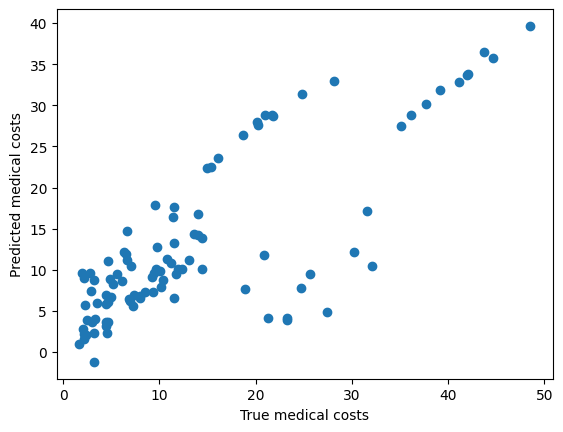

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_test_pred)
plt.xlabel('True medical costs')
plt.ylabel('Predicted medical costs')

In [ ]:
#### 回帰モデルの精度指標
# 分類モデルの場合と同様に、グリッドサーチの精度指標を変更することもできます。
# 以下は、RMSEを精度指標としてグリッドサーチを行う例です。
# ただし、RMSEは低いほど良い値なので、
# 他の制度指標と同様に高いほど良い値にするため、
# RMSEをマイナスした値という意味で'neg_root_mean_squared_error'を指定します。

# グリッドサーチの精度指標にRMSE(をマイナスした値)を使用
gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='neg_root_mean_squared_error')

# RMSEの最も低い(negative RMSEの最も高い)ハイパラを選択
gs.fit(X=X_train, y=y_train)
print('best hyperparameter: {}'.format(gs.best_params_))
print('best negative RMSE: {}'.format(gs.best_score_)) # RMSEをマイナスした値

# テストデータに対する予測精度を評価
y_test_pred = gs.predict(X_test) # 予測値

r2_test = r2_score(y_true=y_test, y_pred=y_test_pred)
rmse_test = root_mean_squared_error(y_true=y_test, y_pred=y_test_pred)
print('R2 on test data: {}'.format(r2_test))
print('RMSE on test data: {}'.format(rmse_test))

best hyperparameter: {'alpha': 2}
best negative RMSE: -5.6020553437041745
R2 on test data: 0.6166301864023147
RMSE on test data: 7.333923744371331


In [ ]:
# R2やRMSE以外の精度指標として、
# ピアソン相関係数やスピアマン順位相関係数もよく使われます。
# これらの指標はsklearnモジュールでは提供されていないため、
# scipyという別のモジュールを使って計算します。
# 以下は、ピアソン相関係数を計算する例です。
from scipy.stats import pearsonr

correlation, p_value = pearsonr(y_test, y_test_pred)
print('Pearson correlation coefficient:\n{}'.format(correlation))
# 関数pearsonr()の戻り値は、相関係数の値(correlation)とその統計的有意性(p_value)です。
# 回帰モデルの精度指標としては、相関係数の値を見るとよいです。

Pearson correlation coefficient:
0.7923998811193919


【課題】上の例にならって、スピアマン順位相関係数を計算して表示してください。スピアマン順位相関係数を計算する関数はspearmanr()です。

In [ ]:
from scipy.stats import spearmanr

correlation =spearmanr(y_test, y_test_pred)
print('Spearman rank correlation coefficient:\n{}'.format(correlation))

Spearman rank correlation coefficient:
SignificanceResult(statistic=np.float64(0.7235940299268722), pvalue=np.float64(3.884982122149592e-17))


【課題】モデルにランダムフォレストを用いて、RMSEを精度指標としてハイパラの最適化を行い、テストデータに対するRMSEを計算して表示してください。上で計算したリッジ回帰のRMSEと比較して、どちらが良かったかコメントの解答欄に書いてください。

*   平等な比較を行うために、学習データ、テストデータ、CVのインスタンスには上の例で作成したのと同じものを流用してください。
*   ランダムフォレストの乱数シード、ハイパラの探索範囲についてはコード内の指定にしたがってください。

In [ ]:
# ランダムフォレストの回帰モデルはRandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# モデルのインスタンスを作成
# seedは上の例と同じものを用いる
model = RandomForestRegressor(random_state=seed)
# ハイパラの探索範囲を指定
# ランダムフォレストの木の数n_estimators
param_grid = {'n_estimators': [10, 20, 50, 100]}

# グリッドサーチの精度指標にRMSEを使用
gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='neg_root_mean_squared_error')

# RMSEの最も良いハイパラを選択
gs.fit(X=X_train, y=y_train)
print('best hyperparameter: {}'.format(gs.best_params_))
print('best negative RMSE: {}'.format(gs.best_score_))

# テストデータに対する予測精度を評価
y_test_pred = gs.predict(X_test) # 予測値
rmse_test = root_mean_squared_error(y_true=y_test, y_pred=y_test_pred)
print('RMSE on test data: {}'.format(rmse_test))

# 解答欄：テストデータに対するRMSEが良かったのは(低かったのは)、リッジ回帰？ランダムフォレスト？
# ランダムフォレスト

best hyperparameter: {'n_estimators': 20}
best negative RMSE: -4.352757291903066
RMSE on test data: 6.4912765799655245
